# Coding of TD($\lambda$) learner algorithm

In [1]:
from platform import python_version
python_version()

'3.7.1'

In [2]:
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

### Based on Chapter 12: Eligibility Traces from Sutton & Barto

### TD($\lambda$)

<IMG SRC="images/tdlambda.png">

### Example 7.1 Random walk

In [3]:
from randomwalk import RandomWalkGame

In [4]:
game = RandomWalkGame(size=19, terminal_rewards={'T1': -1.0, 'T2': 1.0})

In [5]:
game.show_state()

T1 _ _ _ _ _ _ _ _ _ J _ _ _ _ _ _ _ _ _ T2


In [6]:
game.make_move((1, 'r'))
game.show_state()

T1 _ _ _ _ _ _ _ _ _ _ K _ _ _ _ _ _ _ _ T2


In [7]:
game.get_rewards()

{1: 0.0}

## Objective

For verification purposes, we want to replicate the results below which should match Figure 12.8 from the book which looks like this:

<IMG SRC="images/fig_12_8.png">    

## N-Step TD Update - for comparison

In [8]:
def discounted_sequence_generator(sequence, gamma):
    """Returns a generator that yields each item of sequence
    discounted by gamma at each time-step.
    
    Example:
    >>> list(discounted_sequence_generator([10.0]*5, 0.75))
    [10.0, 7.5, 5.625, 4.21875, 3.1640625]
    """
    
    x = 1.0
    for item in sequence:
        yield x*item
        x = x*gamma


def td_n_step_update(value_function, prev_states, prev_rewards, tau, gamma,
                     t_max=np.inf, show=False):
    """Updates the value in value_function for the past state
    that occurred in timestep tau using the n-step TD
    algorithm.
    
    Note:
    tau = t - n + 1

    Where:
        t is the current timestep
        n is the lambda value  

    If tau < 0 no update is possible so none is made.

    Args:
        value_function (dict): Dictionary of state values.
        prev_states (list): List of previous states.
        prev_rewards (list): List of previous rewards.
        tau (int): The timestep of the state that will have
            its value updated.
        gamma (float): Discount rate.
        t_max (int or np.inf): The maximum timestep to include.  
            Set to np.inf or a high number if you want to
            include all timesteps from tau to tau + n.  Set
            to t if the game has eneded.
    """

    assert len(prev_states) == len(prev_rewards)

    if tau >= 0:

        assert tau < len(prev_states), "Not enough past states."

        discounted_rewards = discounted_sequence_generator(
            prev_rewards[tau+1:min(tau + n, t_max) + 1], 
            gamma
        )
        g = sum(list(discounted_rewards))

        if tau + n < t_max:
            g += gamma**n * value_function[prev_states[tau + n]]

        # Update value of state at timestep tau
        state_key = prev_states[tau]
        state_value = value_function[state_key]

        if show:
            print(f"prev_states[{tau}]: {state_value}")

        value_function[state_key] = state_value + \
            learning_rate * (g - state_value)

        if show:
            print(f"value_function[{state_key.__repr__()}]: {value_function[state_key]}")


## TD($\lambda$)

In [9]:
class ValueApproxFunction():
    
    def __init__(self, game):

        self.states = [s for s in game.states if not s in game.terminal_states]
        self.n_states = len(self.states)
        self.terminal_states = [s for s in game.terminal_states]
        self.weights = np.zeros(2)  # Linear function approximator
        self.z = np.full_like(self.weights, 0)  # Eligibility trace vector

    def map_inputs(self, state_key):
        """Convert discrete state value into a linear feature
        value.
        
        returns:
            x (float): (0 <= x <= 1).
        """
        return self.states.index(state_key) / (self.n_states - 1)
    
    def value(self, state_key):
        """Returns estimate of value of state.
        """
        if state_key in self.terminal_states:
            return 0
        x = self.map_inputs(state_key)
        return self.weights[0] + self.weights[1] * x

    def dw(self, state_key):
        """Partial derivatives of value function w.r.t.
        weights at given state.
        """
        if state_key in self.terminal_states:
            return np.array([1.0, 0.0])
        x = self.map_inputs(state_key)
        return np.array([1.0, x])

In [10]:
value_function = ValueApproxFunction(game)

# Mapping states to a single input feature
pd.Series({s: value_function.map_inputs(s) for s in value_function.states})

A    0.000000
B    0.055556
C    0.111111
D    0.166667
E    0.222222
F    0.277778
G    0.333333
H    0.388889
I    0.444444
J    0.500000
K    0.555556
L    0.611111
M    0.666667
N    0.722222
O    0.777778
P    0.833333
Q    0.888889
R    0.944444
S    1.000000
dtype: float64

In [11]:
value_function.weights

array([0., 0.])

In [12]:
value_function.value('J')

0.0

In [13]:
# Partial derivative w.r.t. weights
value_function.dw('J')

array([1. , 0.5])

In [14]:
def td_lambda_update(value_function, prev_state, state, reward, t, lam, gamma, show=False):
    """Updates the value in value_function for the past state
    using the TD-Lambda algorithm.
    
    Args:
        value_function (ValueApproxFunction): Value function approximator.
        state (str): State key.
        reward (float): Reward value.
        z (array): Eligibility trace vector.
        t (int): The timestep of the state that will have
            its value updated.
        gamma (float): Discount factor.
    """

    value_function.z = gamma * lam * value_function.z + value_function.dw(state_key)
    td_error = reward + gamma * value_function.value(prev_state) - value_function.value(state)
    value_function.weights += learning_rate * td_error * value_function.z

    if show:
        print(f"value_function[{state_key.__repr__()}]: {state_value}")

# Test 1 - Single Episode / Walk Right

## (a) N-Step TD Updates

In [25]:
# General TD parameters
gamma = 1.0
learning_rate = 0.1
initial_value = 0.0

# N-step TD parameters
n = 10
value_function = {state_key: initial_value for state_key in game.states}

# Environment setup
game = RandomWalkGame(size=19, terminal_rewards={'T1': -1.0, 'T2': 1.0})
actions = ['r']*10
role = 1

prev_states = [game.start_state]
prev_rewards = [None]
t = 0
while not game.game_over:

    # Behaviour policy
    move = (role, actions[t])
    game.make_move(move)

    # Get rewards
    if not game.game_over:
        reward = game.get_rewards()[role]
    else:
        reward = game.get_terminal_rewards()[role]

    state_key = game.generate_state_key(game.state, role)
    prev_states.append(state_key)
    prev_rewards.append(reward)

    if not game.game_over:
        # Update the value for state in timestep tau
        tau = t - n + 1
        td_n_step_update(value_function, prev_states, prev_rewards, 
                         tau, gamma)

    # Update timestep
    t += 1

assert game.game_over

# Complete final state-value updates for timesteps tau
# to current (terminal) timestep
for tau in range(t - n, t):
    td_n_step_update(value_function, prev_states, prev_rewards, tau, gamma,
                     t_max=t)

# Value function after 1 episode
pd.Series(value_function)

T1    0.0
A     0.0
B     0.0
C     0.0
D     0.0
E     0.0
F     0.0
G     0.0
H     0.0
I     0.0
J     0.1
K     0.1
L     0.1
M     0.1
N     0.1
O     0.1
P     0.1
Q     0.1
R     0.1
S     0.1
T2    0.0
dtype: float64

## (b) TD($\lambda$) With Linear Input Map

In [16]:
# General TD parameters
gamma = 1.0
learning_rate = 0.1
initial_value = 0.0

# TD-Lambda parameters
value_function = ValueApproxFunction(game)
lam = 0.5

# Environment setup
game = RandomWalkGame(size=19, terminal_rewards={'T1': -1.0, 'T2': 1.0})
actions = ['r']*10
role = 1

prev_states = [game.start_state]
prev_rewards = [None]
t = 0
while not game.game_over:

    # Behaviour policy
    move = (role, actions[t])
    game.make_move(move)

    # Get rewards
    if not game.game_over:
        reward = game.get_rewards()[role]
    else:
        reward = game.get_terminal_rewards()[role]

    state_key = game.generate_state_key(game.state, role)
    prev_state = prev_states[-1]
    prev_states.append(state_key)
    prev_rewards.append(reward)

    if not game.game_over:
        # Update the value for state in timestep tau
        td_lambda_update(value_function, prev_state, state_key, 
                         reward, t, lam, gamma)

    # Update timestep
    t += 1

assert game.game_over

# Complete state-value update for final timestep (to terminal state)
td_lambda_update(value_function, prev_state, state_key, reward, t, lam, gamma)

# Value function after 1 episode
values = {state: value_function.value(state) for state in game.states}
pd.Series(values)

T1    0.000000
A     0.199805
B     0.205047
C     0.210289
D     0.215531
E     0.220773
F     0.226015
G     0.231257
H     0.236499
I     0.241741
J     0.246984
K     0.252226
L     0.257468
M     0.262710
N     0.267952
O     0.273194
P     0.278436
Q     0.283678
R     0.288920
S     0.294162
T2    0.000000
dtype: float64

# Test 2 - 10 Episodes Alternating Right, Left, Right, ... etc.

## (a) N-Step TD Updates

In [17]:
n_runs = 10

# General TD parameters
gamma = 1.0
learning_rate = 0.1
initial_value = 0.0

# N-step TD parameters
n = 10
value_function = {state_key: initial_value for state_key in game.states}

# Environment setup
game = RandomWalkGame(size=19, terminal_rewards={'T1': -1.0, 'T2': 1.0})
#actions = ['r']*10
actions = ['r', 'l', 'r', 'l', 'r', 'l', 'r', 'l', 'r', 'l']
role = 1

saved_values = []
for episode in range(0, n_runs):
    game.reset()
    action = actions[episode]  # Different action each episode

    prev_states = [game.start_state]
    prev_rewards = [None]
    t = 0
    while not game.game_over:

        # Behaviour policy
        move = (role, action)
        game.make_move(move)

        # Get rewards
        if not game.game_over:
            reward = game.get_rewards()[role]
        else:
            reward = game.get_terminal_rewards()[role]

        state_key = game.generate_state_key(game.state, role)
        prev_states.append(state_key)
        prev_rewards.append(reward)

        if not game.game_over:
            # Update the value for state in timestep tau
            tau = t - n + 1
            td_n_step_update(value_function, prev_states, prev_rewards, 
                             tau, gamma)

        # Update timestep
        t += 1

    assert game.game_over

    # Complete final state-value updates for timesteps tau
    # to current (terminal) timestep
    for tau in range(t - n, t):
        td_n_step_update(value_function, prev_states, prev_rewards, 
                         tau, gamma, t_max=t)
    
    saved_values.append(pd.Series(value_function, name=episode))

# Final value estimates
print(pd.Series(value_function))

T1    0.00000
A    -0.40951
B    -0.40951
C    -0.40951
D    -0.40951
E    -0.40951
F    -0.40951
G    -0.40951
H    -0.40951
I    -0.40951
J    -0.03428
K     0.40951
L     0.40951
M     0.40951
N     0.40951
O     0.40951
P     0.40951
Q     0.40951
R     0.40951
S     0.40951
T2    0.00000
dtype: float64


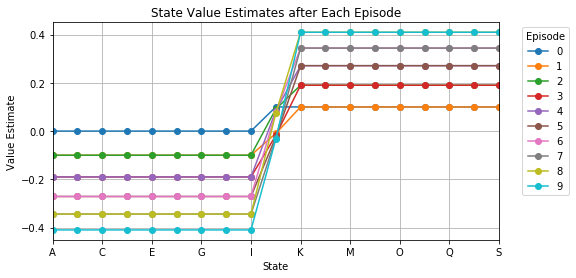

In [18]:
def plot_value_estimates(saved_values):
    terminal_states = game.terminal_states
    combined_results = pd.concat(saved_values, axis=1).drop(terminal_states)
    combined_results.plot(style='o-', figsize=(8,4))
    plt.grid()
    plt.xlabel('State')
    plt.ylabel('Value Estimate')
    plt.title('State Value Estimates after Each Episode')
    plt.legend(title='Episode', bbox_to_anchor=(1.04,1), 
               loc="upper left")
    plt.show()

plot_value_estimates(saved_values)

## (b) TD($\lambda$) With Linear Input Map

In [19]:
n_runs = 10

# General TD parameters
gamma = 1.0
learning_rate = 0.1
initial_value = 0.0

# TD-Lambda parameters
value_function = ValueApproxFunction(game)
lam = 0.5

# Environment setup
game = RandomWalkGame(size=19, terminal_rewards={'T1': -1.0, 'T2': 1.0})
#actions = ['r']*10
actions = ['r', 'l', 'r', 'l', 'r', 'l', 'r', 'l', 'r', 'l']
role = 1

saved_values = []
for episode in range(0, n_runs):
    game.reset()
    action = actions[episode]  # Different action each episode

    prev_states = [game.start_state]
    prev_rewards = [None]
    t = 0
    while not game.game_over:

        # Behaviour policy
        move = (role, action)
        game.make_move(move)

        # Get rewards
        if not game.game_over:
            reward = game.get_rewards()[role]
        else:
            reward = game.get_terminal_rewards()[role]

        state_key = game.generate_state_key(game.state, role)
        prev_state = prev_states[-1]
        prev_states.append(state_key)
        prev_rewards.append(reward)

        if not game.game_over:
            # Update the value for state in timestep tau
            td_lambda_update(value_function, prev_state, state_key, 
                             reward, t, lam, gamma)

        # Update timestep
        t += 1

    assert game.game_over

    # Complete state-value update for final timestep (to terminal state)
    td_lambda_update(value_function, prev_state, state_key, 
                     reward, t, lam, gamma)

    values = {state: value_function.value(state) for state in game.states}
    saved_values.append(pd.Series(values, name=episode))

# Final value estimates
print(pd.Series(values))

T1    0.000000
A     0.949148
B     0.983344
C     1.017540
D     1.051736
E     1.085932
F     1.120128
G     1.154324
H     1.188520
I     1.222716
J     1.256912
K     1.291107
L     1.325303
M     1.359499
N     1.393695
O     1.427891
P     1.462087
Q     1.496283
R     1.530479
S     1.564675
T2    0.000000
dtype: float64


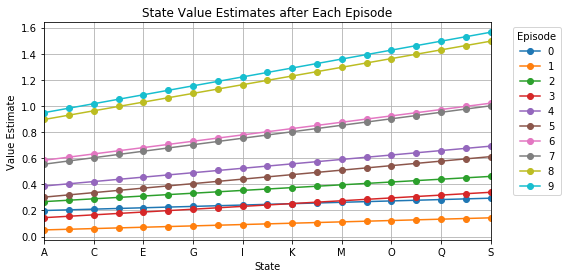

In [20]:
plot_value_estimates(saved_values)

# Test 3 - 10 Episodes with Random Walk

## (a) N-Step TD Updates

In [21]:
n_runs = 10

# General TD parameters
gamma = 1.0
learning_rate = 0.1
initial_value = 0.0

# N-step TD parameters
n = 10
value_function = {state_key: initial_value for state_key in game.states}

# Environment setup
game = RandomWalkGame(size=19, terminal_rewards={'T1': -1.0, 'T2': 1.0})
actions = ['r', 'l']
role = 1

saved_values = []
for episode in range(0, n_runs):
    game.reset()

    prev_states = [game.start_state]
    prev_rewards = [None]
    t = 0
    while not game.game_over:

        # Behaviour policy
        action = random.choice(actions)
        move = (role, action)
        game.make_move(move)

        # Get rewards
        if not game.game_over:
            reward = game.get_rewards()[role]
        else:
            reward = game.get_terminal_rewards()[role]

        state_key = game.generate_state_key(game.state, role)
        prev_states.append(state_key)
        prev_rewards.append(reward)

        if not game.game_over:
            # Update the value for state in timestep tau
            tau = t - n + 1
            td_n_step_update(value_function, prev_states, prev_rewards, 
                             tau, gamma)

        # Update timestep
        t += 1

    assert game.game_over

    # Complete final state-value updates for timesteps tau
    # to current (terminal) timestep
    for tau in range(t - n, t):
        td_n_step_update(value_function, prev_states, prev_rewards, 
                         tau, gamma, t_max=t)
    
    saved_values.append(pd.Series(value_function, name=episode))

# Final value estimates
print(pd.Series(value_function))

T1    0.000000
A    -0.569533
B    -0.612580
C    -0.641751
D    -0.600760
E    -0.270394
F    -0.166660
G    -0.107514
H    -0.091461
I    -0.051443
J     0.010334
K    -0.004935
L     0.108834
M     0.174241
N     0.260776
O     0.387016
P     0.586426
Q     0.611161
R     0.633498
S     0.559031
T2    0.000000
dtype: float64


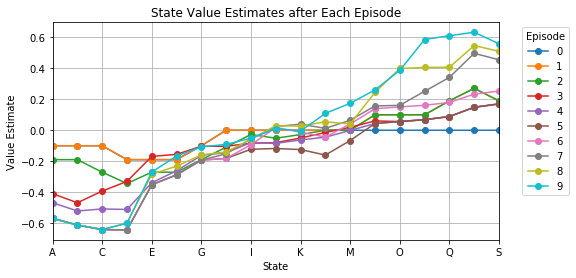

In [22]:
plot_value_estimates(saved_values)

## (b) TD($\lambda$) With Linear Input Map

In [26]:
n_runs = 10

# General TD parameters
gamma = 1.0
learning_rate = 0.1
initial_value = 0.0

# TD-Lambda parameters
value_function = ValueApproxFunction(game)
lam = 0.5

# Environment setup
game = RandomWalkGame(size=19, terminal_rewards={'T1': -1.0, 'T2': 1.0})
actions = ['r', 'l']
role = 1

saved_values = []
for episode in range(0, n_runs):
    game.reset()

    prev_states = [game.start_state]
    prev_rewards = [None]
    t = 0
    while not game.game_over:

        # Behaviour policy
        action = random.choice(actions)
        move = (role, action)
        game.make_move(move)

        # Get rewards
        if not game.game_over:
            reward = game.get_rewards()[role]
        else:
            reward = game.get_terminal_rewards()[role]

        state_key = game.generate_state_key(game.state, role)
        prev_state = prev_states[-1]
        prev_states.append(state_key)
        prev_rewards.append(reward)

        if not game.game_over:
            # Update the value for state in timestep tau
            td_lambda_update(value_function, prev_state, state_key, 
                             reward, t, lam, gamma)

        # Update timestep
        t += 1

    assert game.game_over

    # Complete state-value update for final timestep (to terminal state)
    td_lambda_update(value_function, prev_state, state_key, 
                     reward, t, lam, gamma)

    values = {state: value_function.value(state) for state in game.states}
    saved_values.append(pd.Series(values, name=episode))

# Final value estimates
print(pd.Series(values))

T1    0.000000
A    -0.209407
B    -0.190615
C    -0.171823
D    -0.153032
E    -0.134240
F    -0.115448
G    -0.096656
H    -0.077865
I    -0.059073
J    -0.040281
K    -0.021489
L    -0.002698
M     0.016094
N     0.034886
O     0.053678
P     0.072469
Q     0.091261
R     0.110053
S     0.128845
T2    0.000000
dtype: float64


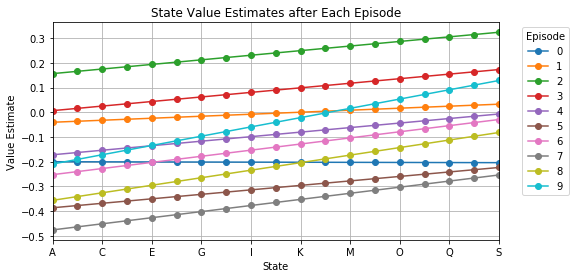

In [27]:
plot_value_estimates(saved_values)